### Import Libraries

In [1]:
from src.diffusion.ddpm import DDPM
from src.diffusion.unet import UNet
from src.data.mnist import get_mnist_loader_and_transform
from src.data.cifar10 import get_cifar10_loader_and_transform
from torchvision.utils import save_image, make_grid
from src.diffusion.train import train
import matplotlib.pyplot as plt

import torch.backends
import torch.backends.mps
import os

### Configuration of model

In [2]:
T = 1000
os.makedirs("projects/diffusion/stable-diffusion-from-scratch/loss", exist_ok=True)
dataset = "mnist" # can be "cifar10" or "mnist"

#PATH_TO_READY_MODEL = None # input path for ready model

PATH_TO_READY_MODEL = "model.pth"
EPOCHS = 50 # for cifar10 it should be more than 1000, but for mnist 20-100 should be okay

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


### Load dataset

In [4]:
if dataset == "mnist":
    data = get_mnist_loader_and_transform()
elif dataset == "cifar10":
    data = get_cifar10_loader_and_transform()

### Setup Model

In [5]:
ddpm = DDPM(
    T = T,
    eps_model=UNet(
        in_channels=data.in_channels,
        out_channels=data.out_channels,
        T=T+1,
        steps=data.recommended_steps,
        attn_step_indexes=data.recommended_attn_step_indexes
    ),
    device=device
)

### Train or load ready model

In [6]:
if PATH_TO_READY_MODEL is not None:
    ddpm.load_state_dict(torch.load(PATH_TO_READY_MODEL, map_location=device))
else:
    training_losses, val_losses = train(
        model=ddpm,
        optimizer=torch.optim.Adam(params=ddpm.parameters(), lr=2e-4),
        epochs=EPOCHS,
        device=device,
        train_dataloader=data.train_loader,
        val_dataloader=data.val_loader
    )

    path = PATH_TO_SAVE_MODEL if PATH_TO_SAVE_MODEL is not None else "model.pth"

    torch.save(ddpm.state_dict(), path)


    
    

In [7]:
# 生成时间戳，避免文件名冲突
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 方案1：保存为图像
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss", linewidth=2)
    plt.plot(val_losses, label="Validation Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss Curves (Final: Train={train_losses[-1]:.6f}, Val={val_losses[-1]:.6f})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    # 确保loss文件夹存在
    os.makedirs(loss, exist_ok=True)
    # 保存图像
    img_path = os.path.join(loss, f"loss_curves_{timestamp}.png")
    plt.savefig(img_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✅ Loss曲线图像已保存到: {img_path}")

IndentationError: unexpected indent (3843111013.py, line 2)

### Show samples

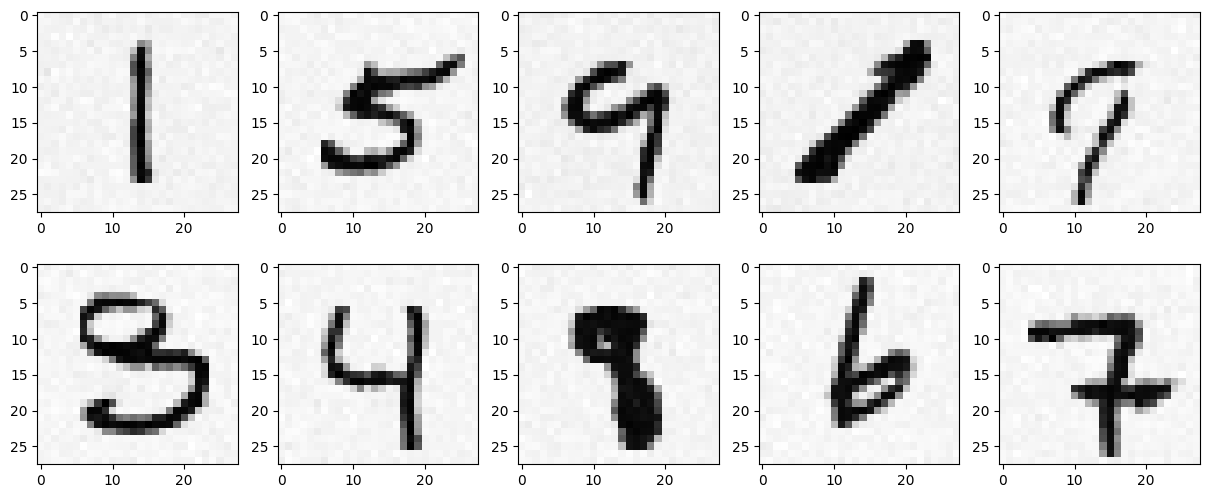

In [8]:
n_samples = 10
x_t = ddpm.sample(n_samples=n_samples, size=data.train_dataset[0][0].shape)

result = []
for i in range(x_t.shape[0]):
    result.append(data.transform_to_pil(x_t[i]))

grid = make_grid(x_t, nrow=10)
save_image(grid, f"sample.png")

cols = 5
rows = (n_samples // cols) + (0 if n_samples % cols == 0 else 1)
fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
for i in range(len(result)):
    row = i // cols
    axs[row, i % cols].imshow(result[i], cmap='gray')
    


#os.system("/usr/bin/shutdown")